# Fine-Tuning a Linear Layer on Frozen Features from Self-Supervised Pretraining

In this notebook, we perform "linear probing," which is a process of fitting a shallow MLP on top of frozen features from a backbone network which was trained in a self-supervised manner. Specifically, we'll be training an MLP on the representations and projector head outputs from our FastSiam model which was trained on the entire dataset without labels. We investigate how good our image classification performance can get using these features with just 1\%, 10\%, and 20\% of the total labels in our dataset.

## Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassAUROC,
    MulticlassF1Score,
)
from torchvision.transforms.functional import InterpolationMode
from tqdm import tqdm
from umap import UMAP


sns.set_theme()
pl.seed_everything(0)

Global seed set to 0


0

## Loading in Trained Model and Data Splits

In [2]:
from ..models.model import FastSiam

ckpt_path = "lightning_logs/version_8/checkpoints/epoch=9-step=15560.ckpt"
model = FastSiam.load_from_checkpoint(ckpt_path)

In [3]:
root = "data/cleaned_splits"
train_1_split = pd.read_pickle(f"{root}/train_1_split.pkl")
train_10_split = pd.read_pickle(f"{root}/train_10_split.pkl")
train_20_split = pd.read_pickle(f"{root}/train_20_split.pkl")
val_data = pd.read_pickle(f"{root}/val_data.pkl")
test_data = pd.read_pickle(f"{root}/test_data.pkl")

We use pandarallel to speed up array to tensor transforms using multiprocessing. From https://nalepae.github.io/pandarallel/troubleshooting/:
> On Windows, because of the multiprocessing system (spawn), the function you send to pandarallel must be self contained, and should not depend on external resources.

We define a set of transforms that contain no augmentations, but simply resize the images correctly and puts them in a format that our model expects.

In [4]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

def array_transforms(array):
    import torchvision.transforms as T
    from torchvision.transforms.functional import InterpolationMode

    transforms = T.Compose([
        T.ToPILImage(),
        T.Resize([128, 128], interpolation=InterpolationMode.NEAREST),
        T.Grayscale(num_output_channels=3),
        T.ToTensor(),
    ])

    return transforms(array)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


## UMAP Embeddings of Representations

Before diving into our linear probe experiments, we first visualize the representation features, projector head outputs, and predictor head outputs for our FastSiam model. We visualize these embeddings on the 1\%, 10\%, and 20\% splits (we also show the embeddings on the validation and test sets to show that our visual representations seem to have the same "shape" in high-dimensional space across all splits).

100%|██████████| 623/623 [00:59<00:00, 10.49it/s]


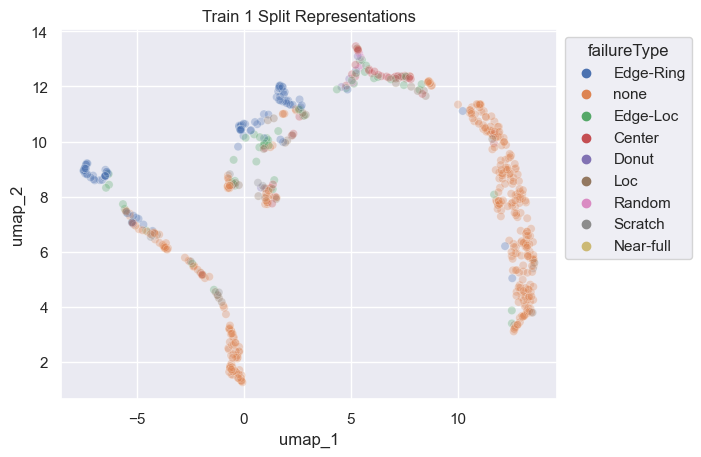

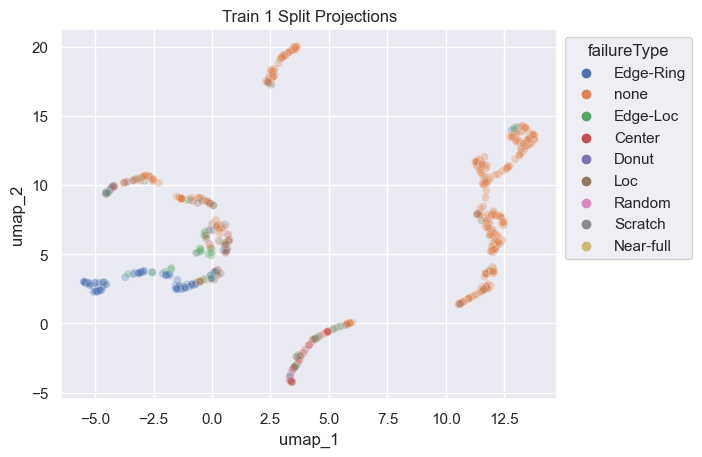

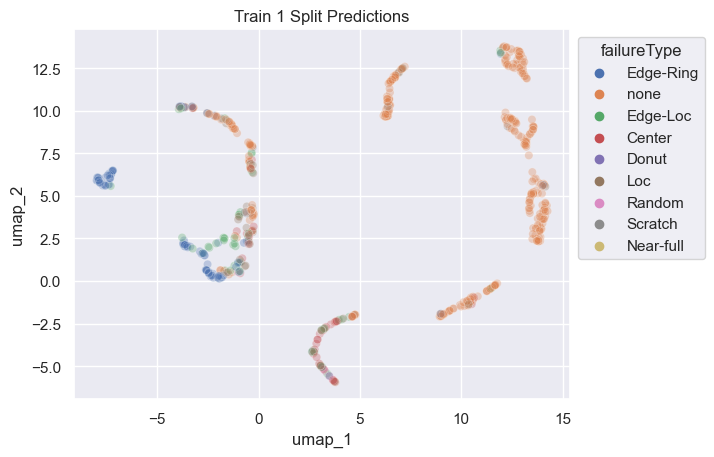

100%|██████████| 6225/6225 [08:20<00:00, 12.43it/s]


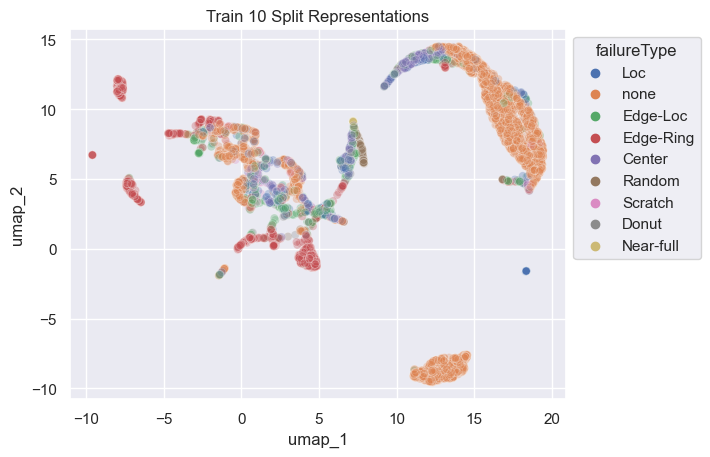

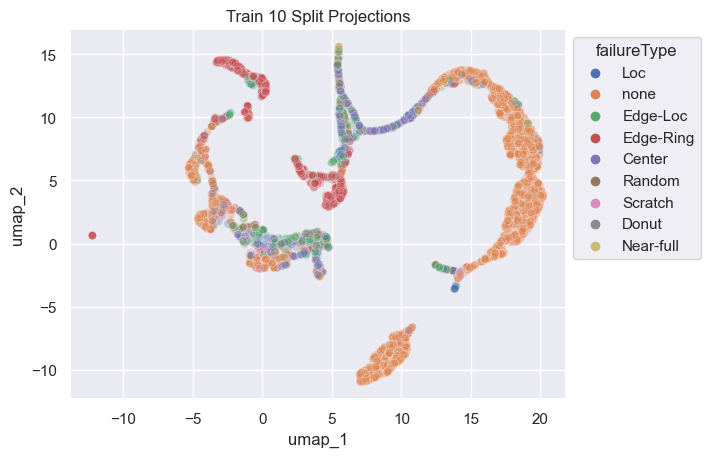

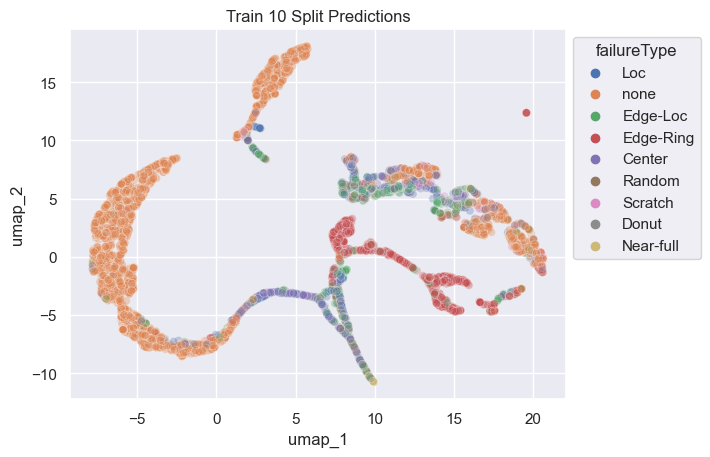

100%|██████████| 12449/12449 [17:29<00:00, 11.86it/s]


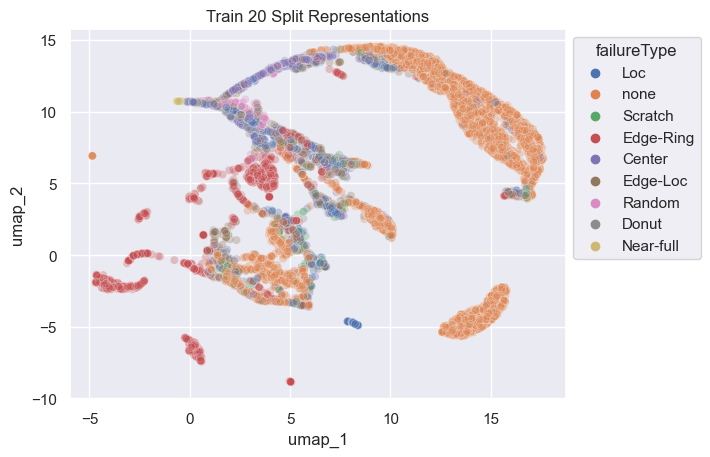

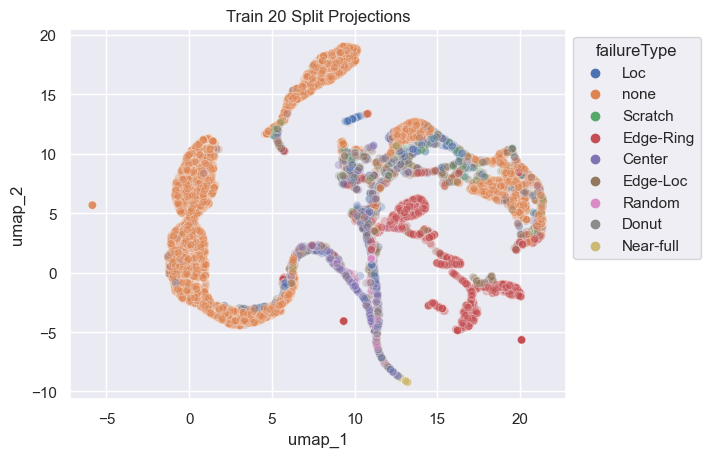

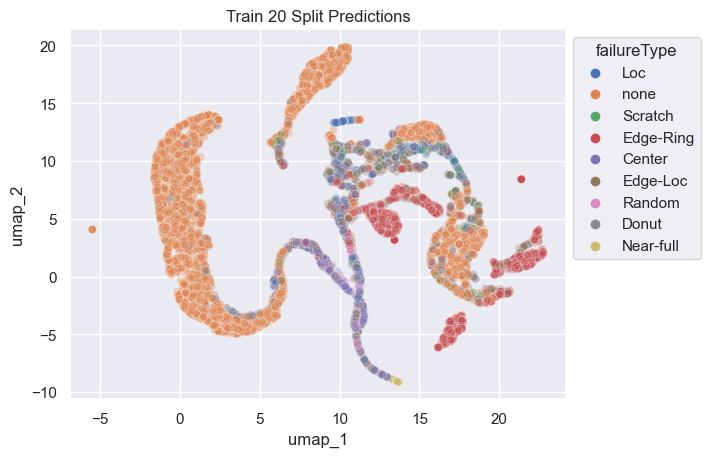

In [6]:
def analyze_embeddings(train_split, name=""):
    train_inputs = train_split.waferMap.parallel_apply(array_transforms)
    train_tensor = torch.stack([_ for _ in train_inputs.values])

    reps = []
    projs = []
    preds = []

    # Frozen model: just use the model as an encoder
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(train_tensor.shape[0])):
            img_tensor = train_tensor[i]
            img_tensor = img_tensor.unsqueeze(dim=0)

            h = model.backbone(img_tensor).flatten(start_dim=1)
            z = model.projection_head(h)
            p = model.prediction_head(z)

            h = h.flatten()
            z = z.flatten()
            p = p.flatten()

            reps.append(h)
            projs.append(z)
            preds.append(p)

    reps_stacked = torch.stack(reps).numpy()
    projs_stacked = torch.stack(projs).numpy()
    preds_stacked = torch.stack(preds).numpy()

    df_reps = pd.DataFrame(reps_stacked)
    df_reps["failureCode"] = train_split.failureCode.values

    df_proj = pd.DataFrame(projs_stacked)
    df_proj["failureCode"] = train_split.failureCode.values

    df_pred = pd.DataFrame(preds_stacked)
    df_pred["failureCode"] = train_split.failureCode.values

    reducer = UMAP(metric="euclidean")
    scaler = StandardScaler()

    titles = ["Representations", "Projections", "Predictions"]

    for count, representations in enumerate(
        (reps_stacked, projs_stacked, preds_stacked)
    ):
        reducer = UMAP(metric="cosine")
        scaler = StandardScaler()
        embedding = reducer.fit_transform(scaler.fit_transform(representations))
        emb_df = pd.DataFrame(
            {
                "umap_1": embedding[:, 0],
                "umap_2": embedding[:, 1],
                "failureType": train_split.failureType,
            }
        )
        ax = sns.scatterplot(
            data=emb_df, x="umap_1", y="umap_2", hue="failureType", alpha=0.3
        )
        emb_df.to_csv(f"data/umap/{name} {titles[count]}.csv", index=False)
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        plt.title(f"{name} {titles[count]}")
        plt.show()

    df_reps.to_csv(f"data/representations/{name} reps.csv", index=False)
    df_proj.to_csv(f"data/projections/{name} proj.csv", index=False)
    df_pred.to_csv(f"data/predictions/{name} pred.csv", index=False)


os.makedirs("data/umap/", exist_ok=True)
os.makedirs("data/representations/", exist_ok=True)
os.makedirs("data/projections/", exist_ok=True)
os.makedirs("data/predictions/", exist_ok=True)

analyze_embeddings(train_1_split, "Train 1 Split")
analyze_embeddings(train_10_split, "Train 10 Split")
analyze_embeddings(train_20_split, "Train 20 Split")

100%|██████████| 12450/12450 [16:53<00:00, 12.28it/s]


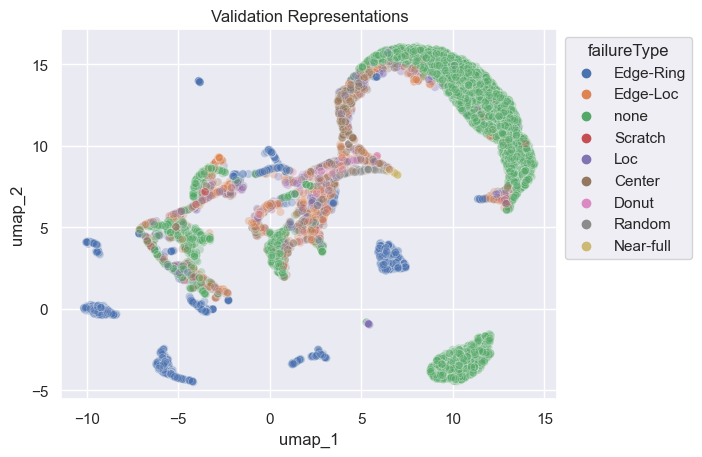

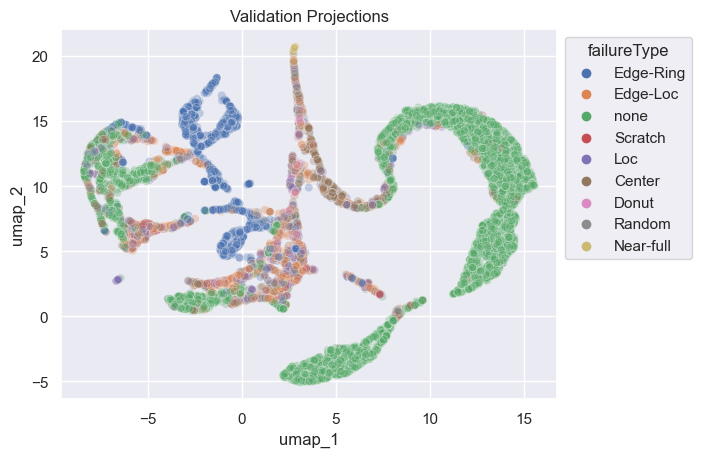

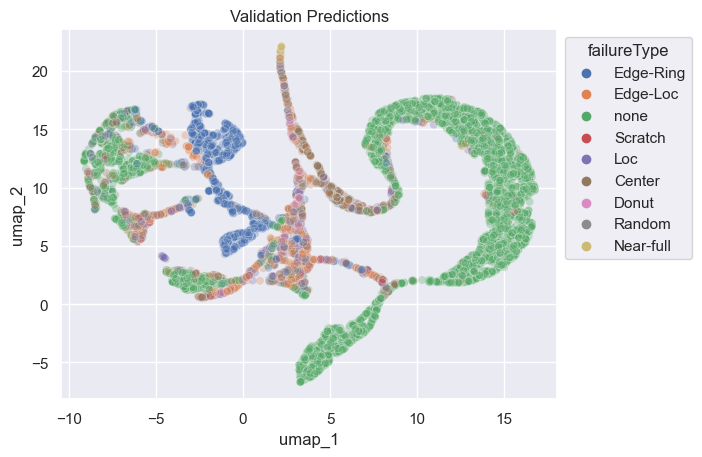

100%|██████████| 12450/12450 [16:40<00:00, 12.45it/s]


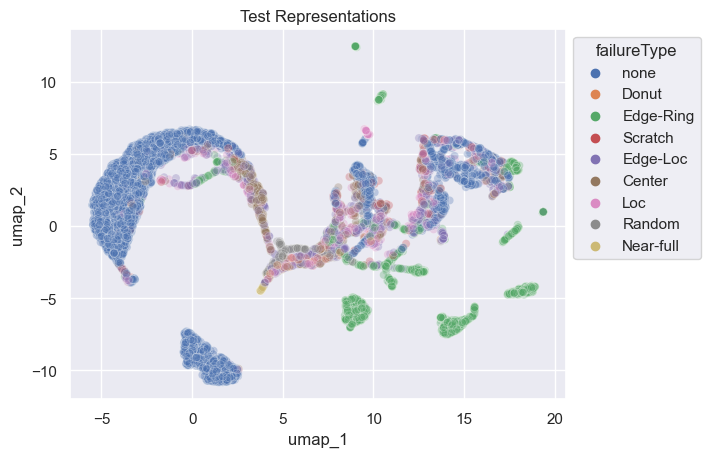

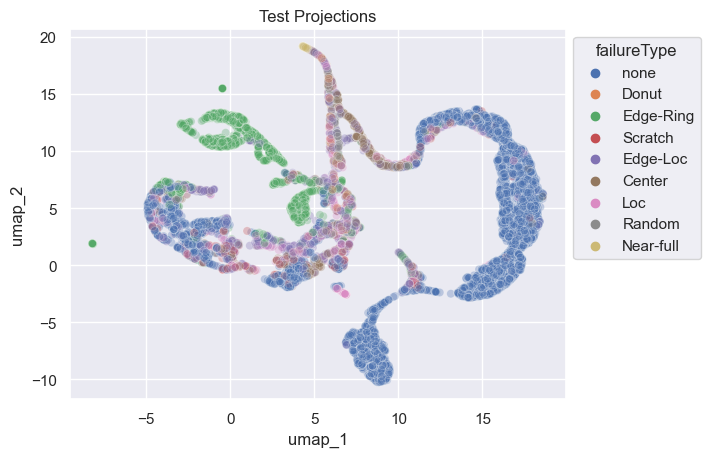

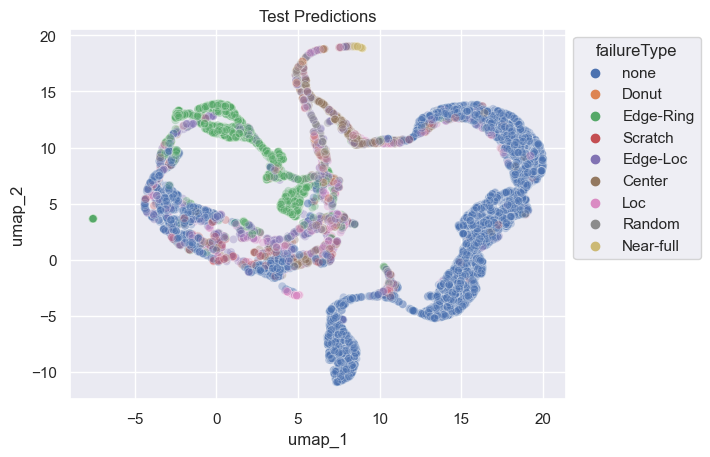

In [7]:
analyze_embeddings(val_data, "Validation")
analyze_embeddings(test_data, "Test")

Qualitatively, it appears that the representations $h = f(x)$, projections $z = g(h)$, and predictions $p$ all form nice clusters in a high-dimensional space. It almost appears as if the projections and predictions form tighter clusters than the representations in high-dimensional space. Nevertheless, we follow the conjecture of the authors of SimCLR in using just the backbone encoder $f$ and representations $h$ for downstream tasks instead of $z$ or $p$. From that paper: 

> *After training is completed, we throw away the projection head $g(·)$ and use encoder $f(·)$ and representation $h$ for downstream tasks.*
> 
> ...
> 
> *We conjecture that the importance of using the representation before the nonlinear projection is due to loss of information induced by the contrastive loss. In particular, $z = g(h)$ is trained to be invariant to data transformation. Thus, $g$ can remove information that may be useful for the downstream task, such as the color or orientation of objects*

Similarly from SimSiam, the authors mention using just the representations straight from the backbone.

> *Given the pre-trained network, we train a supervised linear classifier on frozen features, which are from ResNet’s global average pooling layer pool $_5$*

## Linear Probe Experiments

### Datasets from Frozen Features

One option for linear probing is to create a module that expects images as inputs, just like a fully supervised ResNet or our FastSiam model from self-supervised training. However, it's much easier to create datasets from the frozen features and train a shallow neural network on top of those. That way, we won't have to pass images through our FastSiam's ResNet backbone for every forward pass.

In [4]:
# Load in representations
rep_dir = "data/representations"
train_1_reps = pd.read_csv(f"{rep_dir}/Train 1 Split reps.csv")
train_10_reps = pd.read_csv(f"{rep_dir}/Train 10 Split reps.csv")
train_20_reps = pd.read_csv(f"{rep_dir}/Train 20 Split reps.csv")
val_reps = pd.read_csv(f"{rep_dir}/Validation reps.csv")
test_reps = pd.read_csv(f"{rep_dir}/Test reps.csv")

# Show format of representations to the reader 😉
train_1_reps  # first 512 columns are representations, last is label

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,failureCode
0,0.837331,0.349649,0.203633,0.232021,1.111885,0.623043,0.157074,0.753885,0.721967,0.174655,...,1.635406,1.142601,0.119089,0.754680,0.481495,0.995523,0.152785,0.177633,1.186508,3
1,0.398227,0.530708,0.941446,1.005675,0.575373,0.426713,0.213530,0.866461,0.111522,1.205460,...,0.339019,0.544625,0.299267,0.469847,0.550252,0.485877,1.140228,0.602495,0.538500,8
2,0.421432,0.399247,0.458564,0.337619,0.530168,0.970016,0.256423,0.737565,0.555517,0.090002,...,0.659193,0.804461,0.251419,0.967825,0.827770,0.541027,0.192970,0.214226,0.746179,2
3,0.336978,0.474762,0.481993,0.525960,0.519148,0.714434,0.078820,0.648382,0.067228,0.416992,...,0.368381,0.991838,0.015383,0.823778,0.942351,0.580949,0.458146,0.166027,0.679961,8
4,0.159357,0.597375,0.988315,0.732828,0.370818,0.475649,0.129089,0.745479,0.085225,0.532024,...,0.270402,0.477094,0.095093,0.615135,0.712482,0.313727,0.492622,0.279688,0.723674,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,0.465285,0.410302,0.389581,0.339987,0.692302,0.625696,0.106510,0.681975,0.258516,0.234484,...,0.829404,1.024600,0.038046,0.794708,0.775180,0.731366,0.307093,0.125585,0.923699,4
619,0.262862,0.498522,0.483787,0.468205,0.411921,0.734915,0.079502,0.613690,0.070033,0.327069,...,0.363357,0.952515,0.006139,0.875397,0.962147,0.472738,0.432524,0.179713,0.725830,8
620,0.567078,0.491819,0.926837,1.127266,0.707507,0.362397,0.428179,0.918865,0.389941,1.338425,...,0.425942,0.381755,0.603173,0.416672,0.421741,0.624881,1.147519,0.694373,0.535777,4
621,0.568984,0.283371,0.215865,0.091505,0.824998,1.227855,0.108187,0.728350,0.900885,0.076583,...,1.635988,0.917527,0.067242,1.010033,0.320051,0.605626,0.011694,0.470929,0.979453,3


In [5]:
class TensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).type(torch.float32)
        self.y = torch.tensor(y).type(torch.LongTensor)
        self.data = (X, y)

    def __getitem__(self, index):
        x = self.X[index]
        y = self.y[index]
        return x, y

    def __len__(self):
        return len(self.X)

### Linear Probe Module

This is the fully supervised shallow MLP. We use several classification metrics from [torchmetrics](https://torchmetrics.readthedocs.io/en/stable/) to monitor performance on the training, validation, and test sets.

In [6]:
class LinearProbe(pl.LightningModule):
    def __init__(self, input_dim=512, hidden_dim=512, num_classes=9):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Mish(),
            nn.Linear(hidden_dim, num_classes)
        )

        # Note that MulticlassAccuracy and MulticlassAUROC use macro averaging by default
        self.val_accuracy = MulticlassAccuracy(num_classes=num_classes, average="macro")
        self.val_auroc = MulticlassAUROC(num_classes=num_classes, average="macro")
        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average="macro")

        self.test_accuracy = MulticlassAccuracy(num_classes=num_classes)
        self.test_auroc = MulticlassAUROC(num_classes=num_classes)
        self.test_f1 = MulticlassF1Score(num_classes=num_classes, average="macro")

    def forward(self, x):
        out = self.fc(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        # preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(logits, y)
        self.val_auroc.update(logits, y)
        self.val_f1.update(logits, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
        self.log("val_auroc", self.val_auroc, prog_bar=True)
        self.log("val_f1", self.val_f1, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(logits, y)
        self.test_auroc.update(logits, y)
        self.test_f1.update(logits, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        self.log("test_auroc", self.test_auroc, prog_bar=True)
        self.log("test_f1", self.test_f1, prog_bar=True)

    def configure_optimizers(self):
        optim = torch.optim.AdamW(self.parameters(), lr=5e-4, amsgrad=True)
        return optim

### Training, Validating, and Testing

The `train_val_test` function creates datasets and dataloaders from the train, validation, and test data that is passed in. The frozen features from the train sets are first scaled using scikit-learn's `StandardScaler`, and the statistics from the scaler on the training set are used to transform the validation and test sets, avoiding any data leakage.

We then train the MLP with early stopping based on the validation loss (training will end early if the validation loss does not improve for a certain number of epochs). After training is complete, the Accuracy, AUROC, and F1 scores are displayed for the test set.

In [13]:
def train_val_test(
    train_data,
    val_data,
    test_data,
    batch_size=256,
    input_dim=512,
    hidden_dim=512,
    num_classes=9,
):
    X_train = train_data[train_data.columns[:-1]]
    y_train = train_data.failureCode

    X_val = val_data[val_data.columns[:-1]]
    y_val = val_data.failureCode

    X_test = test_data[test_data.columns[:-1]]
    y_test = test_data.failureCode

    # Scale the representations before using them for deep learning
    scaler = StandardScaler()
    # Fit scaler to statistics of X_train
    X_train = scaler.fit_transform(X_train)
    # Use scaler statistics from only training data on val/test data, avoiding data leakage
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, drop_last=False
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, drop_last=False
    )

    probe_model = LinearProbe(input_dim, hidden_dim, num_classes)

    accelerator = "gpu" if torch.cuda.is_available() else "cpu"

    trainer = pl.Trainer(
        max_epochs=10000,
        accelerator=accelerator,
        devices=-1,
        callbacks=[
            EarlyStopping(
                monitor="val_loss",
                mode="min",
                patience=100 if len(train_data) < 1000 else 30,
            )
        ],
        # Epochs are really short and fast, so progress bar gets bugged
        enable_progress_bar=False,
    )
    trainer.fit(probe_model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.test(probe_model, test_loader)

    # delete model and trainer + free up cuda memory
    del probe_model
    del trainer
    # torch.cuda.empty_cache()

In [11]:
import warnings

# suppress annoying torchmetrics and lightning warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*meaningless.*")
warnings.filterwarnings("ignore", ".*log_every_n_steps.*")

# Fine-tune and evaluate on 1%, then 10%, then 20% of the labeled data
for train_reps in (train_1_reps, train_10_reps, train_20_reps):
    train_val_test(train_reps, val_reps, test_reps)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | fc            | Sequential         | 267 K 
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | val_auroc     | MulticlassAUROC    | 0     
3 | val_f1        | MulticlassF1Score  | 0     
4 | test_accuracy | MulticlassAccuracy | 0     
5 | test_auroc    | MulticlassAUROC    | 0     
6 | test_f1       | MulticlassF1Score  | 0     
-----------------------------------------------------
267 K     Trainable params
0         Non-trainable params
267 K     Total params
1.069     Total estimated model params size (MB)
c:\Users\khanm\anaconda3\envs\deeplearning2\lib\site-packages\pytorch_lightning\trainer\trainer.py:1595: PossibleUserWarning: The number of training batches (2) is smaller than the lo

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.662934422492981
       test_auroc            0.956318736076355
         test_f1             0.657538890838623
        test_loss           0.46841374039649963
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | fc            | Sequential         | 267 K 
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | val_auroc     | MulticlassAUROC    | 0     
3 | val_f1        | MulticlassF1Score  | 0     
4 | test_accuracy | MulticlassAccuracy | 0     
5 | test_auroc    | MulticlassAUROC    | 0     
6 | test_f1       | MulticlassF1Score  | 0     
-----------------------------------------------------
267 K     Trainable params
0         Non-trainable params
267 K     Total params
1.069     Total estimated model params size (MB)
c:\Users\khanm\anaconda3\envs\deeplearning2\lib\site-packages\pytorch_lightning\trainer\trainer.py:1595: PossibleUserWarning: The number of training batches (24) is smaller than the l

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7529496550559998
       test_auroc           0.9868562817573547
         test_f1            0.7552675008773804
        test_loss           0.2514304518699646
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | fc            | Sequential         | 267 K 
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | val_auroc     | MulticlassAUROC    | 0     
3 | val_f1        | MulticlassF1Score  | 0     
4 | test_accuracy | MulticlassAccuracy | 0     
5 | test_auroc    | MulticlassAUROC    | 0     
6 | test_f1       | MulticlassF1Score  | 0     
-----------------------------------------------------
267 K     Trainable params
0         Non-trainable params
267 K     Total params
1.069     Total estimated model params size (MB)
c:\Users\khanm\anaconda3\envs\deeplearning2\lib\site-packages\pytorch_lightning\trainer\trainer.py:1595: PossibleUserWarning: The number of training batches (48) is smaller than the l

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7862070798873901
       test_auroc           0.9894624352455139
         test_f1            0.7918055057525635
        test_loss           0.21707960963249207
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Now, we repeat, but this time we use the outputs of FastSiam's projector head instead of the raw outputs from its ResNet-18 backbone.

In [15]:
# Load in projections
proj_dir = "data/projections"
train_1_proj = pd.read_csv(f"{proj_dir}/Train 1 Split proj.csv")
train_10_proj = pd.read_csv(f"{proj_dir}/Train 10 Split proj.csv")
train_20_proj = pd.read_csv(f"{proj_dir}/Train 20 Split proj.csv")
val_proj = pd.read_csv(f"{proj_dir}/Validation proj.csv")
test_proj = pd.read_csv(f"{proj_dir}/Test proj.csv")

train_1_proj.shape  # projections are 1024 dimensions

(623, 1025)

In [16]:
# Fine-tune and evaluate on 1%, then 10%, then 20% of the labeled data
for train_proj in (train_1_proj, train_10_proj, train_20_proj):
    train_val_test(train_proj, val_proj, test_proj, input_dim=1024)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | fc            | Sequential         | 529 K 
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | val_auroc     | MulticlassAUROC    | 0     
3 | val_f1        | MulticlassF1Score  | 0     
4 | test_accuracy | MulticlassAccuracy | 0     
5 | test_auroc    | MulticlassAUROC    | 0     
6 | test_f1       | MulticlassF1Score  | 0     
-----------------------------------------------------
529 K     Trainable params
0         Non-trainable params
529 K     Total params
2.118     Total estimated model params size (MB)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5684729814529419
       test_auroc           0.9265861511230469
         test_f1            0.5379257798194885
        test_loss           0.6284895539283752
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | fc            | Sequential         | 529 K 
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | val_auroc     | MulticlassAUROC    | 0     
3 | val_f1        | MulticlassF1Score  | 0     
4 | test_accuracy | MulticlassAccuracy | 0     
5 | test_auroc    | MulticlassAUROC    | 0     
6 | test_f1       | MulticlassF1Score  | 0     
-----------------------------------------------------
529 K     Trainable params
0         Non-trainable params
529 K     Total params
2.118     Total estimated model params size (MB)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6791404485702515
       test_auroc           0.9775081276893616
         test_f1            0.6819804310798645
        test_loss           0.32442718744277954
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | fc            | Sequential         | 529 K 
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | val_auroc     | MulticlassAUROC    | 0     
3 | val_f1        | MulticlassF1Score  | 0     
4 | test_accuracy | MulticlassAccuracy | 0     
5 | test_auroc    | MulticlassAUROC    | 0     
6 | test_f1       | MulticlassF1Score  | 0     
-----------------------------------------------------
529 K     Trainable params
0         Non-trainable params
529 K     Total params
2.118     Total estimated model params size (MB)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7488245964050293
       test_auroc           0.9849995374679565
         test_f1             0.748587965965271
        test_loss           0.2582540214061737
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


We see that performance is slightly worse when using these projected features. This is in line with observations from the authors of SimCLR and SimSiam.